In [44]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sgp4.api import Satrec, jday
from datetime import datetime, timedelta, timezone
from dateutil.relativedelta import relativedelta
import io
import sys
import math
import configparser

import astropy.units as u
from astropy.coordinates import TEME, ITRS, CartesianRepresentation, EarthLocation
from astropy.time import Time
from astropy.utils.iers import conf

In [45]:
config = configparser.ConfigParser()
config.read('config.ini')

SPACETRACK_USER = config['SPACE_TRACK']['username']
SPACETRACK_PASS = config['SPACE_TRACK']['password']
SPACETRACK_URI = "https://www.space-track.org"
SPACETRACK_LOGIN_URL = SPACETRACK_URI + '/ajaxauth/login'
SPACETRACK_LOGOUT_URL = SPACETRACK_URI + '/ajaxauth/logout'
SPACETRACK_QUERY_URL = SPACETRACK_URI + '/basicspacedata/query'

In [46]:
NORAD_ID = 23560 # ERS-2
MONTHS_PRIOR = 3

In [47]:
# Last TIP message time (UTC)
MSG_EPOCH_STR_TIP = "2024-02-21 18:51:00"

In [48]:
GM_EARTH = 3.986008e14 # Standard gravitational parameter (m^3/s^2)

In [49]:
def calculate_epoch_dt(satrec_obj):
    """Calculates timezone-aware UTC datetime object from Satrec epoch fields."""
    year = satrec_obj.epochyr
    if year < 57:  # Y2K fix
        year += 2000
    else:
        year += 1900
    day = satrec_obj.epochdays
    day_int = int(day)
    frac_day = day - day_int
    base_date = datetime(year, 1, 1, tzinfo=timezone.utc) # Make base date UTC aware
    # Add timedelta, result remains UTC aware
    dt_epoch = base_date + timedelta(days=day_int - 1, seconds=frac_day * 86400.0)
    return dt_epoch

In [50]:
print(f"Attempting to fetch data for NORAD ID: {NORAD_ID}...")

latest_tle_data = None
tle_data = None
latest_epoch_dt = None
tle_line1_latest = None
tle_line2_latest = None
sat_latest = None

with requests.Session() as session:
    # Login
    login_data = {'identity': SPACETRACK_USER, 'password': SPACETRACK_PASS}
    session.post(SPACETRACK_LOGIN_URL, data=login_data).raise_for_status()
    print("Space-Track login successful.")

    # Fetch Latest TLE
    latest_tle_query_url = (f"{SPACETRACK_QUERY_URL}/class/tle/"
                           f"NORAD_CAT_ID/{NORAD_ID}/orderby/EPOCH%20desc/limit/1/format/tle")
    latest_tle_response = session.get(latest_tle_query_url)
    latest_tle_response.raise_for_status()
    latest_tle_data = latest_tle_response.text.strip()
    print("Fetched latest TLE.")

    # Parse Latest TLE and Determine Date Range
    if not latest_tle_data or len(latest_tle_data.splitlines()) < 2:
        print(f"Error: No valid latest TLE data found for NORAD ID {NORAD_ID}. Exiting.")
        sys.exit(1)

    latest_lines = latest_tle_data.splitlines()
    tle_line1_latest = latest_lines[-2].strip()
    tle_line2_latest = latest_lines[-1].strip()

    if tle_line1_latest.startswith('1 ') and tle_line2_latest.startswith('2 '):
        sat_latest = Satrec.twoline2rv(tle_line1_latest, tle_line2_latest)
        latest_epoch_dt = calculate_epoch_dt(sat_latest)
    else:
        print(f"Error: Fetched latest data does not look like a valid TLE:\n{latest_tle_data}\nExiting.")
        sys.exit(1)

    # Calculate Date Range for Historical Data
    END_DATE_dt = latest_epoch_dt
    START_DATE_dt = END_DATE_dt - relativedelta(months=MONTHS_PRIOR)
    END_DATE_str = END_DATE_dt.strftime('%Y-%m-%d')
    START_DATE_str = START_DATE_dt.strftime('%Y-%m-%d')

    print(f"Latest TLE Epoch: {latest_epoch_dt.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]} UTC")
    print(f"Querying historical TLEs from {START_DATE_str} to {END_DATE_str}")

    # Fetch Historical TLEs for the Date Range
    query_url = (f"{SPACETRACK_QUERY_URL}/class/tle/NORAD_CAT_ID/{NORAD_ID}/"
                f"EPOCH/{START_DATE_str}--{END_DATE_str}/orderby/EPOCH%20asc/format/tle")
    tle_response = session.get(query_url)
    tle_response.raise_for_status()
    tle_data = tle_response.text
    print(f"Successfully fetched historical TLE data ({len(tle_data.splitlines()) // 2} sets found).")

    # Logout
    session.get(SPACETRACK_LOGOUT_URL)
    print("Logged out from Space-Track.")

# Final check for required data
if tle_data is None or latest_epoch_dt is None or sat_latest is None:
    print("Error: Failed to retrieve necessary data from Space-Track. Exiting.")
    sys.exit(1)

Attempting to fetch data for NORAD ID: 23560...
Space-Track login successful.
Fetched latest TLE.
Latest TLE Epoch: 2024-02-21 15:49:35.026 UTC
Querying historical TLEs from 2023-11-21 to 2024-02-21
Successfully fetched historical TLE data (303 sets found).
Logged out from Space-Track.


In [51]:
print("Parsing historical TLEs...")
lines = tle_data.strip().splitlines()
tles = []
line_idx = 0
while line_idx < len(lines) - 1:
    line1 = lines[line_idx].strip()
    line2 = lines[line_idx+1].strip()

    if not line1 or not line2:
        line_idx += 1
        continue

    if line1.startswith('1 ') and line2.startswith('2 '):
        try:
            sat = Satrec.twoline2rv(line1, line2)
            dt_epoch = calculate_epoch_dt(sat) # Get UTC datetime

            # Extract ndot/2 directly from TLE Line 1 (columns 34-43) - Optional, SGP4 uses internal value
            # Keeping original parsing logic, but note SGP4 uses sat.ndot internally
            ndot_raw = line1[33:43].strip()
            ndot_formatted = "0.0" # Default value
            if ndot_raw:
                # Add implicit decimal point if missing
                if '.' not in ndot_raw and len(ndot_raw) > 1:
                    sign = ''
                    if ndot_raw.startswith(('-', '+')):
                        sign = ndot_raw[0]
                        ndot_raw = ndot_raw[1:]
                    # Simplified exponent handling
                    num_part = ndot_raw
                    exp_part = ''
                    if '-' in ndot_raw[1:]: # Check for exponent sign after potential leading sign
                       parts = ndot_raw.rsplit('-',1)
                       if len(parts)==2 and parts[1].isdigit() and parts[0].isdigit():
                           num_part = parts[0]
                           exp_part = '-'+parts[1]
                    elif '+' in ndot_raw[1:]:
                       parts = ndot_raw.rsplit('+',1)
                       if len(parts)==2 and parts[1].isdigit() and parts[0].isdigit():
                           num_part = parts[0]
                           exp_part = '+'+parts[1]

                    if exp_part:
                        ndot_formatted = f"{sign}.{num_part}e{exp_part}"
                    else: # No exponent found, just add decimal
                        ndot_formatted = f"{sign}.{num_part}"
                else: # Already has decimal or is simple (e.g., '0')
                    ndot_formatted = ndot_raw

                # Final cleanup attempts for various scientific notations
                ndot_formatted = ndot_formatted.replace(' -','e-').replace(' +','e+') # Common format
                if 'e' not in ndot_formatted: # Handle cases like .12345-5
                     last_sign_idx = max(ndot_formatted.rfind('-'), ndot_formatted.rfind('+'))
                     if last_sign_idx > 0 and ndot_formatted[last_sign_idx-1].isdigit(): # Ensure sign follows a digit
                        base = ndot_formatted[:last_sign_idx]
                        exponent = ndot_formatted[last_sign_idx:]
                        try:
                            float(base) # Check base is numeric
                            int(exponent) # Check exponent is numeric
                            ndot_formatted = base + 'e' + exponent
                        except ValueError:
                            pass # Not a valid split for scientific notation

            # Now parse the scientific notation
            try:
                ndot_term = float(ndot_formatted)
            except ValueError:
                print(f"Warning: Could not parse ndot_term '{line1[33:43]}' (processed as '{ndot_formatted}') for TLE epoch {dt_epoch}. Setting to 0.")
                ndot_term = 0.0

            # Store parameters
            mean_motion_rad_min = sat.no_kozai # Mean motion in rad/min (used by SGP4)
            mean_motion_rev_day = mean_motion_rad_min * (1440.0 / (2.0 * np.pi)) # Convert to rev/day

            tles.append({
                'Epoch': dt_epoch, # Store UTC datetime
                'MeanMotion_rad_min': mean_motion_rad_min,
                'MeanMotion_revday': mean_motion_rev_day,
                'Eccentricity': sat.ecco,
            })
            line_idx += 2  # Move to the next pair

        except Exception as e:
            print(f"ERROR processing TLE lines:\n{line1}\n{line2}\nError: {e}. Skipping pair.")
            line_idx += 2 # Skip this problematic pair

    else:
        # Skipping non-TLE line
        line_idx += 1

if not tles:
    print("No valid TLEs could be parsed from the downloaded historical data. Exiting.")
    sys.exit(1)

print(f"Successfully parsed {len(tles)} historical TLE sets.")
tle_df_raw = pd.DataFrame(tles)

Parsing historical TLEs...
Successfully parsed 303 historical TLE sets.


In [52]:
print("Calculating derived parameters for historical data...")
tle_df_raw['MeanMotion_rad_sec'] = tle_df_raw['MeanMotion_rad_min'] / 60.0
n_rad_per_sec = tle_df_raw['MeanMotion_rad_sec']

# Calculate Semi-Major Axis (SMA) in meters
valid_n = n_rad_per_sec > 1e-9 
tle_df_raw['SemiMajorAxis_m'] = np.nan
tle_df_raw.loc[valid_n, 'SemiMajorAxis_m'] = (GM_EARTH / n_rad_per_sec[valid_n]**2)**(1.0/3.0)
tle_df_raw['SemiMajorAxis_km'] = tle_df_raw['SemiMajorAxis_m'] / 1000.0

# Calculate Orbital Period in seconds
tle_df_raw['Period_sec'] = np.nan
tle_df_raw.loc[valid_n, 'Period_sec'] = 2.0 * np.pi / n_rad_per_sec[valid_n]

# Calculate Perigee and Apogee Altitudes
R_EARTH_KM_FOR_PLOT = 6378.135 
valid_sma = tle_df_raw['SemiMajorAxis_m'].notna()
tle_df_raw['AltitudePerigee_km'] = np.nan
tle_df_raw['AltitudeApogee_km'] = np.nan

rp_m = tle_df_raw.loc[valid_sma, 'SemiMajorAxis_m'] * (1.0 - tle_df_raw.loc[valid_sma, 'Eccentricity'])
ra_m = tle_df_raw.loc[valid_sma, 'SemiMajorAxis_m'] * (1.0 + tle_df_raw.loc[valid_sma, 'Eccentricity'])

tle_df_raw.loc[valid_sma, 'AltitudePerigee_km'] = (rp_m / 1000.0) - R_EARTH_KM_FOR_PLOT
tle_df_raw.loc[valid_sma, 'AltitudeApogee_km'] = (ra_m / 1000.0) - R_EARTH_KM_FOR_PLOT


original_rows = len(tle_df_raw)
essential_cols = ['SemiMajorAxis_m', 'AltitudePerigee_km', 'AltitudeApogee_km', 'Period_sec']
tle_df = tle_df_raw.dropna(subset=essential_cols).copy()
dropped_rows = original_rows - len(tle_df)
if dropped_rows > 0:
    print(f"Dropped {dropped_rows} historical rows due to invalid derived parameter calculations.")

if tle_df.empty:
    print("No valid historical data remains after calculating derived parameters. Cannot plot decay. Exiting.")
    sys.exit(1)

print("Historical derived parameter calculation complete.")
tle_df.set_index('Epoch', inplace=True)
tle_df.sort_index(inplace=True)

Calculating derived parameters for historical data...
Historical derived parameter calculation complete.


Plotting historical altitude decay...


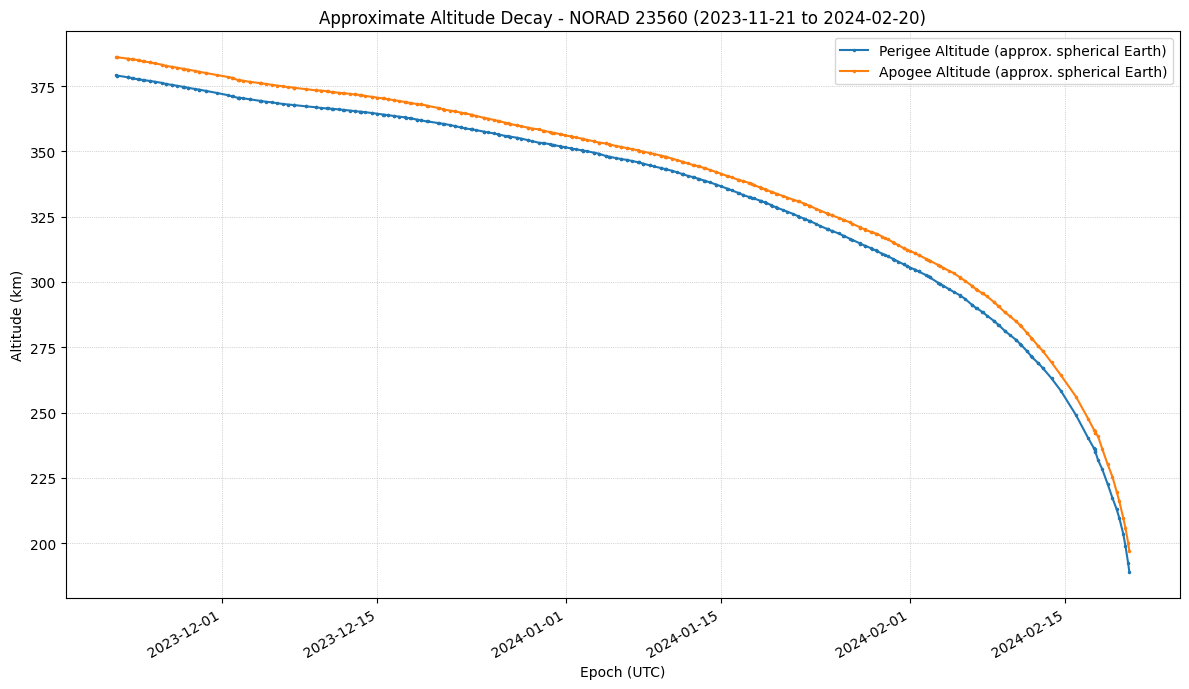

In [53]:
print("Plotting historical altitude decay...")
fig1, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(tle_df.index, tle_df['AltitudePerigee_km'], marker='.', markersize=3, linestyle='-', label='Perigee Altitude (approx. spherical Earth)')
ax1.plot(tle_df.index, tle_df['AltitudeApogee_km'], marker='.', markersize=3, linestyle='-', label='Apogee Altitude (approx. spherical Earth)')
ax1.set_xlabel('Epoch (UTC)')
ax1.set_ylabel('Altitude (km)')
ax1.set_title(f'Approximate Altitude Decay - NORAD {NORAD_ID} ({tle_df.index.min().strftime("%Y-%m-%d")} to {tle_df.index.max().strftime("%Y-%m-%d")})')
ax1.legend()
ax1.grid(True, which='both', linestyle=':', linewidth=0.5)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
fig1.autofmt_xdate()
plt.tight_layout()
plt.show()

In [54]:
print("\n--- Calculating Position and Geodetic Altitude at Specific TIP Message Epoch ---")
print(f"Attempting calculation for NORAD ID: {NORAD_ID}")
print(f"Using the latest TLE fetched previously, with Epoch:")
print(f"  {latest_epoch_dt.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]} UTC") 
print(f"  TLE Line 1: {tle_line1_latest}")
print(f"  TLE Line 2: {tle_line2_latest}")

msg_epoch_dt_tip = datetime.strptime(MSG_EPOCH_STR_TIP, '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
print(f"\nTarget Propagation Epoch (UTC): {msg_epoch_dt_tip.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

jd_tip, fr_tip = jday(msg_epoch_dt_tip.year, msg_epoch_dt_tip.month, msg_epoch_dt_tip.day,
                     msg_epoch_dt_tip.hour, msg_epoch_dt_tip.minute, msg_epoch_dt_tip.second + msg_epoch_dt_tip.microsecond / 1e6)

print("Propagating using SGP4...")
error_code_tip, position_km_tip, velocity_km_s_tip = sat_latest.sgp4(jd_tip, fr_tip)

if error_code_tip != 0:
    print(f"Warning: SGP4 propagation returned error code {error_code_tip}. Results may be inaccurate.")

altitude_wgs84_km = None
latitude_wgs84_deg = None
longitude_wgs84_deg = None

print("Converting SGP4 TEME output to ITRS...")
propagation_time_astropy = Time(msg_epoch_dt_tip, scale='utc')

teme_pos_meters = CartesianRepresentation(x=position_km_tip[0] * 1000.0 * u.m,
                                          y=position_km_tip[1] * 1000.0 * u.m,
                                          z=position_km_tip[2] * 1000.0 * u.m)

teme_coord = TEME(teme_pos_meters, obstime=propagation_time_astropy)
itrs_coord = teme_coord.transform_to(ITRS(obstime=propagation_time_astropy))
print("Conversion to ITRS successful.")

print("Calculating Geodetic Altitude (WGS84)...")
geodetic_location = itrs_coord.earth_location.to_geodetic('WGS84')
altitude_wgs84_km = geodetic_location.height.to(u.km).value
latitude_wgs84_deg = geodetic_location.lat.to(u.deg).value
longitude_wgs84_deg = geodetic_location.lon.to(u.deg).value
print("Geodetic calculation successful.")


--- Calculating Position and Geodetic Altitude at Specific TIP Message Epoch ---
Attempting calculation for NORAD ID: 23560
Using the latest TLE fetched previously, with Epoch:
  2024-02-21 15:49:35.026 UTC
  TLE Line 1: 1 23560U 95021A   24052.65943318  .32169375  33451-5  24835-3 0  9997
  TLE Line 2: 2 23560  98.4779  71.8096 0011047 264.7570 236.2294 16.52434583548081

Target Propagation Epoch (UTC): 2024-02-21 18:51:00.000
Propagating using SGP4...
Converting SGP4 TEME output to ITRS...
Conversion to ITRS successful.
Calculating Geodetic Altitude (WGS84)...
Geodetic calculation successful.


In [55]:
print("\n--- SGP4 Propagation Results (TEME Frame) ---")
print(f"Propagated Position (TEME, km): [{position_km_tip[0]:.3f}, {position_km_tip[1]:.3f}, {position_km_tip[2]:.3f}]")
print(f"Propagated Velocity (TEME, km/s): [{velocity_km_s_tip[0]:.4f}, {velocity_km_s_tip[1]:.4f}, {velocity_km_s_tip[2]:.4f}]")

if altitude_wgs84_km is not None:
    print("\n--- Precise Altitude Calculation Results ---")
    # Optional: Print ITRS position
    # print(f"ITRS Position (m): [X={itrs_coord.x.to(u.m).value:.3f}, Y={itrs_coord.y.to(u.m).value:.3f}, Z={itrs_coord.z.to(u.m).value:.3f}]")
    print(f"Sub-satellite Latitude (WGS84, deg): {latitude_wgs84_deg:.4f}")
    print(f"Sub-satellite Longitude (WGS84, deg): {longitude_wgs84_deg:.4f}")
    print(f"Calculated Geodetic Altitude above WGS84 ellipsoid (km): {altitude_wgs84_km:.3f}")
    print(f"\n---> Final Geodetic Altitude at {MSG_EPOCH_STR_TIP} UTC was approximately {altitude_wgs84_km:.3f} km. <---")
else:
    print("\n--- Precise Altitude Calculation Failed ---")
    # Fallback or indication of failure
    # Calculate approximate altitude using old method for reference if needed
    radius_km_tip = math.sqrt(position_km_tip[0]**2 + position_km_tip[1]**2 + position_km_tip[2]**2)
    approx_alt_km = radius_km_tip - R_EARTH_KM_FOR_PLOT
    print(f"Could not calculate geodetic altitude. Approximate altitude (spherical Earth) is {approx_alt_km:.3f} km.")


--- SGP4 Propagation Results (TEME Frame) ---
Propagated Position (TEME, km): [-1856.088, -6152.311, 924.382]
Propagated Velocity (TEME, km/s): [-1.4354, -0.7191, -7.6717]

--- Precise Altitude Calculation Results ---
Sub-satellite Latitude (WGS84, deg): 8.2391
Sub-satellite Longitude (WGS84, deg): 179.2672
Calculated Geodetic Altitude above WGS84 ellipsoid (km): 114.639

---> Final Geodetic Altitude at 2024-02-21 18:51:00 UTC was approximately 114.639 km. <---



Plotting historical decay with calculated TIP point...


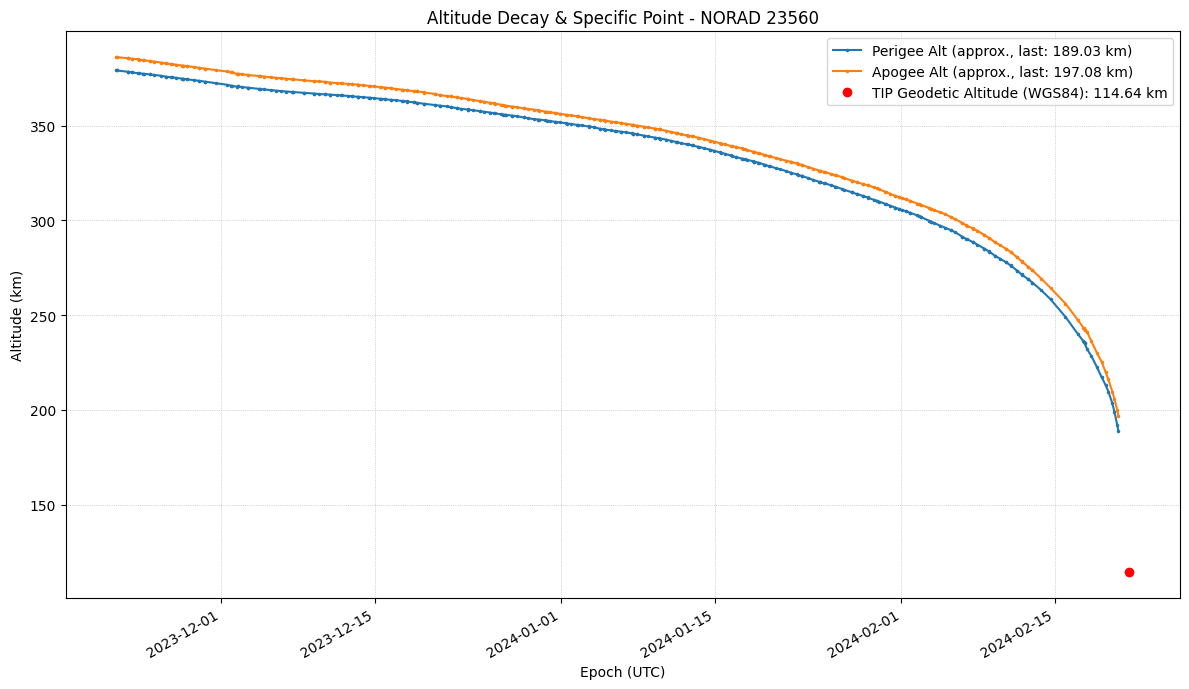

In [56]:
print("\nPlotting historical decay with calculated TIP point...")
fig2, ax2 = plt.subplots(figsize=(12, 7))

# Get the last values of perigee and apogee altitudes from historical plot data
last_perigee = tle_df['AltitudePerigee_km'].iloc[-1]
last_apogee = tle_df['AltitudeApogee_km'].iloc[-1]

# Plot historical data (using approx. spherical earth altitudes)
ax2.plot(tle_df.index, tle_df['AltitudePerigee_km'], marker='.', markersize=3, linestyle='-',
         label=f'Perigee Alt (approx., last: {last_perigee:.2f} km)')
ax2.plot(tle_df.index, tle_df['AltitudeApogee_km'], marker='.', markersize=3, linestyle='-',
         label=f'Apogee Alt (approx., last: {last_apogee:.2f} km)')

# Add the calculated Geodetic Altitude TIP point
if altitude_wgs84_km is not None:
    # Ensure datetime object for plotting is naive if axes expect it (matplotlib usually does)
    tip_time_for_plot = msg_epoch_dt_tip.replace(tzinfo=None)
    ax2.plot(tip_time_for_plot, altitude_wgs84_km, 'ro', markersize=6,
             label=f'TIP Geodetic Altitude (WGS84): {altitude_wgs84_km:.2f} km')
elif 'approx_alt_km' in locals(): # Plot approximate altitude if precise failed
     tip_time_for_plot = msg_epoch_dt_tip.replace(tzinfo=None)
     ax2.plot(tip_time_for_plot, approx_alt_km, 'mo', markersize=6, # Magenta 'm'
             label=f'TIP Approx. Altitude: {approx_alt_km:.2f} km')


ax2.set_xlabel('Epoch (UTC)')
ax2.set_ylabel('Altitude (km)')
ax2.set_title(f'Altitude Decay & Specific Point - NORAD {NORAD_ID}')
ax2.legend()
ax2.grid(True, which='both', linestyle=':', linewidth=0.5)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
fig2.autofmt_xdate()
plt.tight_layout()
plt.show() 